In [ ]:
# If you don't already have mplsoccer installed, you'll need to run this command (for Exercise 6)
!pip install mplsoccer

In [269]:
import numpy as np
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt

shot = pd.read_csv('shot.csv')  # read data from file

'''
## EXERCISE 1 ##
Below, fill in the calculations for distance and angle to goal.
'''

# Create a new dataframe with additional columns
shot_data = (
    shot
        .assign(
            is_goal=lambda x: np.where(x['shot_outcome'] == "Goal", 1, 0),
            # Use the ast.literal_eval function to convert location strings into lists
            # NOTE: This ast.literal_eval function will come in very handy if you
            #       choose to work with the freeze frame data in Assignment #2!
            loc_x=lambda x: [ast.literal_eval(y)[0] for y in x['location']],
            loc_y=lambda x: [ast.literal_eval(y)[1] for y in x['location']],
            distance=lambda x: np.sqrt((x['loc_x'] - 120)**2 + (x['loc_y'] - 40)**2),
            angle=lambda x: [math.atan(y) for y in (x['loc_y'] - 40) / (x['loc_x'] - 120)],
            # Calculate more useful transformations of angle and distance
            sqrt_distance=lambda x: np.sqrt(x['distance']),
            cos_angle=lambda x: [math.cos(y) for y in x['angle']]
        )
)

# Shuffle the rows and separate training set from test set
shot_shuffled = shot_data.sample(frac=1, random_state=42)
shot_train = shot_shuffled[:2000]
shot_test = shot_shuffled[2000:]

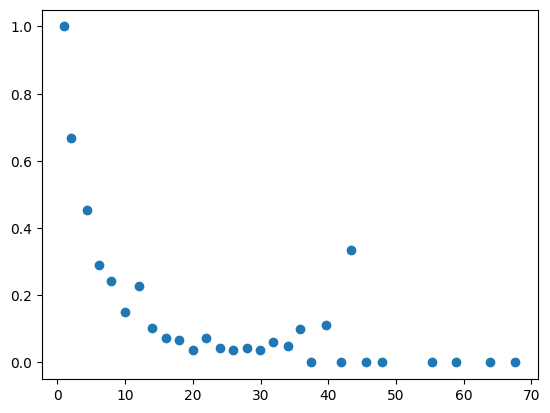

In [270]:
import matplotlib.pyplot as plt

# This block of code calculates the average for all numeric columns within each bucket of distance
# rounded to the nearest two meters, most importantly the average of is_goal within each bucket.
plot_data = (
    shot_data
        # Create rounded_distance, which is distance rounded to the nearest multiple of 2 meters
        .assign(rounded_distance=lambda x: round(x['distance'] / 2) * 2)
        .groupby('rounded_distance')
        .mean(numeric_only=True)
)

'''
## EXERCISE 2 ##
Above, we get the observed rate of goals for each distance, rounded to the nearest two meters.
Plot y = observed goal rate versus x = rounded distance below, to visualize the result.
Does the relationship look linear? What does it look like?
'''

# Perform exploratory data analysis to examine relationship between distance and goal probability
plt.scatter(plot_data['distance'], plot_data['is_goal'])

In [271]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

'''
## EXERCISE 3 ##
Fit a logistic regression model (using training data only) to predict goal probability using only
sqrt_distance and cos_angle. What is the average log probability out the outcomes in the test set?
Hint: Back when we were fitting Bradley-Terry models, we used
smf.glm(..., family=sm.families.Poisson()) to fit a Poisson regression. For logistic regression, try
smf.glm(..., family=sm.families.Binomial()).
'''

# Fit a logistic regression model for goal probability using distance and angle
model = (
    smf.glm(
        formula="is_goal ~ sqrt_distance + cos_angle",
        data=shot_train,
        family=sm.families.Binomial()
    )
        .fit()
)

# Make predictions in the test set and evaluate the log probability of each outcome
shot_test = (
    shot_test
        .assign(
            pred=model.predict(exog=shot_test),
            # Find the predicted probability corresponding to the actual outcome
            prob=lambda x: np.where(x['is_goal'], x['pred'], 1 - x['pred']),
            log_prob=lambda x: np.log(x['prob'])
        )
)

# Calculate the average log probability in the test set
print(np.mean(shot_test['log_prob']))

-0.3300396163027569


In [272]:
'''
## EXERCISE 4 ##
Try experimenting with adding other variables from the data to the model to get a better prediction.
What's the best average log probability you can get in the test set?
'''

# Fit a logistic regression model for goal probability using distance and angle
model = (
    smf.glm(
        formula="is_goal ~ sqrt_distance + cos_angle + sqrt_distance * cos_angle + shot_aerial_won + under_pressure",
        data=shot_train,
        family=sm.families.Binomial()
    )
        .fit()
)

# Make predictions in the test set and evaluate the log probability of each outcome
shot_test = (
    shot_test
        .assign(
            pred=model.predict(exog=shot_test),
            # Find the predicted probability corresponding to the actual outcome
            prob=lambda x: np.where(x['is_goal'], x['pred'], 1 - x['pred']),
            log_prob=lambda x: np.log(x['prob'])
        )
)

# Calculate the average log probability in the test set
print(np.mean(shot_test['log_prob']))

-0.32135406690378676


In [273]:
'''
## EXERCISE 5 ##
Your calculate of the average log probability in the test set has some randomness due to noise.
What is the standard error of your calculation?
'''

# Calculate the standard error for the average log probability
print(np.std(shot_test['log_prob']) / np.sqrt(shot_test.shape[0]))

0.017643594668759834


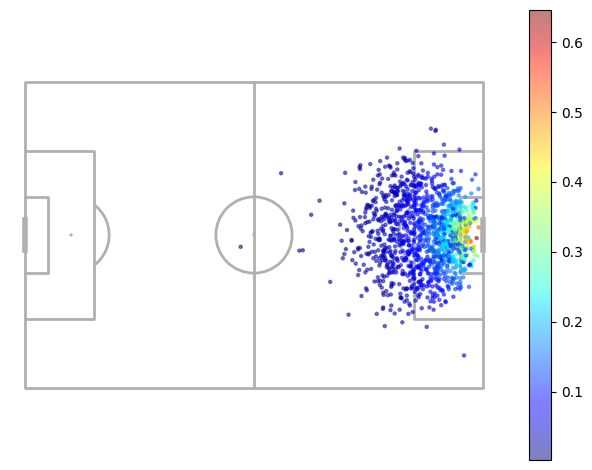

In [274]:
import mplsoccer as mpl

'''
## EXERCISE 6 ##
Below we are plotting a blank soccer pitch. Try plotting all of the test-set shots on this field,
and color them according to their xG.
Hint: Try using pitch.scatter() like Devin Pleuler did in his soccer analytics handbook.
'''

# Draw the soccer pitch
pitch = mpl.Pitch()
fig, ax = pitch.draw()
# Plot the shots from the test set
points = pitch.scatter(
    x=shot_test['loc_x'],
    y=shot_test['loc_y'],
    s=5,
    c=shot_test['pred'],    # color according to xG
    alpha=0.5,
    cmap='jet',
    ax=ax
)
plt.colorbar(points)        # add a legend for interpreting the color